<a href="https://colab.research.google.com/github/IreneJeong/Project-Storage/blob/main/EfficientNet_on_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# installing efficientNet source code
!pip install -U git+https://github.com/qubvel/efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-wdqiuk1q
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/efficientnet /tmp/pip-req-build-wdqiuk1q
  Resolved https://github.com/qubvel/efficientnet to commit f7f3e736c113b872caf53dae9fbbda996a8eb87d
  Preparing metadata (setup.py) ... done


In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import efficientnet.keras as enet


In [ ]:
# loading Cifar-10 dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
!pip uninstall keras
!pip uninstall tensorflow
!pip install tensorflow
!pip install keras


Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/keras-2.12.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/keras/*
Proceed (Y/n)? ?Y
Your response ('?y') was not one of the expected responses: y, n, 
Proceed (Y/n)? Y
  Successfully uninstalled keras-2.12.0
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.9/dist-packages/tensorflow-2.12.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Swish defination
from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import CustomObjectScope

#from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
CustomObjectScope().update({'swish_act': SwishActivation(swish_act)})

ImportError: ignored

In [ ]:
# loading B0 pre-trained on ImageNet without final aka fiature extractor
model = enet.EfficientNetB0(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

# building 2 fully connected layer 
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# output layer
predictions = Dense(10, activation="softmax")(x)

model_final = Model(inputs = model.input, outputs = predictions)

model_final.summary()

16804768/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 16, 16, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 16, 16, 32)   0           ['stem_bn[0][0]']                
                             

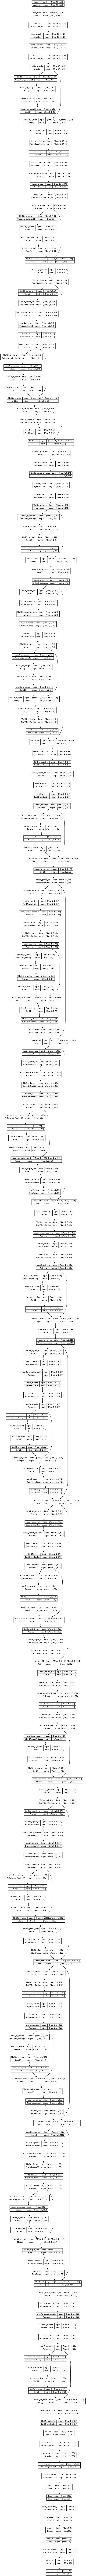

In [ ]:
# ploting keras model for visualization

from keras.utils.vis_utils import plot_model
plot_model(model_final, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# model compilation
model_final.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('EnetB0_CIFAR10_TL.h5', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

#print("Training....")
model_final.fit(x_train, y_train,
              batch_size=32,
              epochs=10,
              validation_split=0.1,
              callbacks=[mcp_save, reduce_lr],
              shuffle=True,
              verbose=1)

Epoch 1/10
1407/1407 [==============================] - ETA: 0s - loss: 1.9207 - accuracy: 0.3272

1407/1407 [==============================] - 81s 43ms/step - loss: 1.9207 - accuracy: 0.3272 - val_loss: 1.2651 - val_accuracy: 0.5756 - lr: 1.0000e-04
Epoch 2/10
1407/1407 [==============================] - ETA: 0s - loss: 1.2125 - accuracy: 0.5827

1407/1407 [==============================] - 62s 44ms/step - loss: 1.2125 - accuracy: 0.5827 - val_loss: 0.8739 - val_accuracy: 0.7040 - lr: 1.0000e-04
Epoch 3/10
1406/1407 [============================>.] - ETA: 0s - loss: 0.9686 - accuracy: 0.6737

1407/1407 [==============================] - 59s 42ms/step - loss: 0.9688 - accuracy: 0.6737 - val_loss: 0.7237 - val_accuracy: 0.7532 - lr: 1.0000e-04
Epoch 4/10
1407/1407 [==============================] - ETA: 0s - loss: 0.8346 - accuracy: 0.7194

1407/1407 [==============================] - 60s 43ms/step - loss: 0.8346 - accuracy: 0.7194 - val_loss: 0.6353 - val_accuracy: 0.7844 - lr: 1.0000e-04
Epoch 5/10
1407/1407 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.7525

1407/1407 [==============================] - 62s 44ms/step - loss: 0.7319 - accuracy: 0.7525 - val_loss: 0.5956 - val_accuracy: 0.7962 - lr: 1.0000e-04
Epoch 6/10
1407/1407 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.7801

1407/1407 [==============================] - 60s 42ms/step - loss: 0.6558 - accuracy: 0.7801 - val_loss: 0.5645 - val_accuracy: 0.8090 - lr: 1.0000e-04
Epoch 7/10
1407/1407 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.8024

1407/1407 [==============================] - 59s 42ms/step - loss: 0.5903 - accuracy: 0.8024 - val_loss: 0.5330 - val_accuracy: 0.8168 - lr: 1.0000e-04
Epoch 8/10
1407/1407 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.8219

1407/1407 [==============================] - 53s 38ms/step - loss: 0.5299 - accuracy: 0.8219 - val_loss: 0.5268 - val_accuracy: 0.8224 - lr: 1.0000e-04
Epoch 9/10
1407/1407 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8371

1407/1407 [==============================] - 58s 41ms/step - loss: 0.4829 - accuracy: 0.8371 - val_loss: 0.5080 - val_accuracy: 0.8238 - lr: 1.0000e-04
Epoch 10/10
1407/1407 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.8534

1407/1407 [==============================] - 58s 41ms/step - loss: 0.4360 - accuracy: 0.8534 - val_loss: 0.5032 - val_accuracy: 0.8286 - lr: 1.0000e-04


In [ ]:
_, acc = model_final.evaluate(x_test, y_test)

NameError: ignored

In [ ]:
print("Test Accuracy: {}%".format(acc*100))

Test Accuracy: 82.02999830245972%


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_pred = model_final.predict(x_test)

313/313 [==============================] - 5s 10ms/step


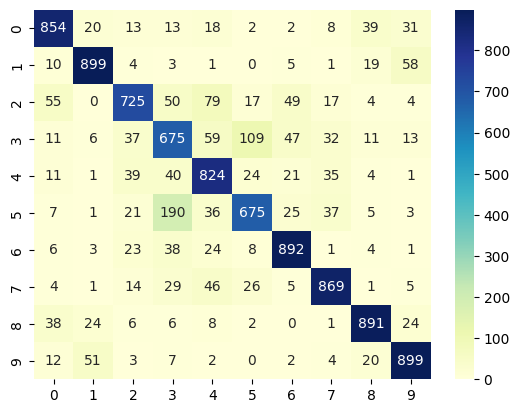

In [ ]:
import numpy as np

ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(test_pred, axis=1)), cmap="YlGnBu",annot=True,fmt="d")

In [ ]:
print(Dahye())

In [ ]:
def mbConv_block(input_data, block_arg):
    """Mobile Inverted Residual block along with Squeeze and Excitation block."""
    kernel_size = block_arg.kernel_size
    num_repeat= block_arg.num_repeat
    input_filters= block_arg.input_filters
    output_filters= output_filters.kernel_size
    expand_ratio= block_arg.expand_ratio
    id_skip= block_arg.id_skip
    strides= block_arg.strides
    se_ratio= block_arg.se_ratio
    # expansion phase
    expanded_filters =  input_filters * expand_ratio
    x = Conv2D(expanded_filters, 1,  padding='same',  use_bias=False)(input_data)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)
    # Depthwise convolution phase
    x = DepthwiseConv2D(kernel_size, strides,  padding='same',  use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)
    # Squeeze and excitation phase
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, expanded_filters ))(x)
    squeezed_filters = max (1, int(input_filters * se_ratio))
    se = Conv2D(squeezed_filters , 1, activation=swish_activation, padding='same')(se)
    se = Conv2D(expanded_filters, 1, activation=’sigmoid’, padding='same')(se)
    x = multiply([x, se])
    # Output phase
    x = Conv2D(output_filters, 1, padding='same', use_bias=False)
    x = BatchNormalization()(x)
    return x


SyntaxError: ignored